<h3><center>Value at Risk (VaR) Analysis<br>
CUNY SPS MSDS<br>
Professor Samuel Gralnick<br>
Team Sugar Cane: Euclid Zhang, Jie Zou, Zhenni Xie<br>
Fall 2022</center></h3>

Value at Risk (VaR) is a financial metric used to estimate the theoretical loss that an investment will not exceed with a defined confidence level or probability.

The method of using VaR to manage financial risk is based on the following assumptions:
- The returns of the investment portfolio are normally distributed
- The distribution of the returns is approximately stable over time

There are many different methods of calculating the VaR. In this analysis we focus on the Parametric Method that estimates the mean and variance of the returns and calculate the corresponding percentile from the normal distribution

In [2]:
#Loading packages

#The yfinance library is used to retrieve asset prices from Yahoo Finance
import yfinance as yf

import numpy as np
from datetime import datetime, timedelta
import pandas_datareader.data as pdr
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt

First, we determine our confidence level (0.95) and the start date and end date of the historical assets prices used to perform our calculation

In [3]:
#Settings for calculating the VaR

#Confidence level of the VaR
confidence_level = 0.95

#The start date and end date of the assets' prices used to calculate the VaR
start = datetime.strptime('2021-09-26', '%Y-%m-%d')
end = datetime.strptime('2022-09-27', '%Y-%m-%d')

Our investment portfolio includes the following assets, with purchaing prices (close prices) from 9/16/2022

In [4]:
#Load the infromation of the assets in our portfolio
assets = pd.read_csv("portfolio assets.csv")
assets

,Ticker,Type,Sector,Price,Units,Amount
0,US30Y,U.S. 30 Year Treasury,NaN,90.44,467317.00,42262981.19
1,HSON,Common Stock,COMMERCIAL SERVICES,34.95,36138.24,1263031.49
2,GOGO,Common Stock,COMMUNICATIONS,13.32,94822.19,1263031.57
3,JAKK,Common Stock,CONSUMER DURABLES,23.37,54044.99,1263031.42
4,CALM,Common Stock,CONSUMER NON-DURABLES,56.85,22216.91,1263031.33
5,HRB,Common Stock,CONSUMER SERVICES,44.93,28111.09,1263031.27
6,HDSN,Common Stock,DISTRIBUTION SERVICES,7.94,159071.98,1263031.52
7,BELFA,Common Stock,ELECTRONIC TECHNOLOGY,28.52,44285.81,1263031.30
8,ARLP,Common Stock,ENERGY MINERALS,23.88,52890.76,1263031.35
9,CI,Common Stock,HEALTH SERVICES,290.35,4350.03,1263031.21


For the U.S. 30 Year Treasury Bonds, we calculate the daily market value of the bonds from the start date to the end date defined aboved. The calculation is based on the implied yield rates from:
https://www.marketwatch.com/investing/bond/tmubmusd30y?countrycode=bx <br>
The values are calculated with the assumption that the **coupons received are not re-invested**, since the coupon is relatively small and the return within one year for that small amount is neglectable.

In [5]:
#Define a function to calculate the market value of the "risk-free" U.S.Treasury Bond, 
#based on the number of days after the bond is purchased, the coupon rate, the implied yield rate,
#the face value, and the maturity.
#The values are calculated with the assumption that the coupons received are not re-invested.
def bond_value(days_after_purchase, coupon_rate, yield_rate, face_value, maturity):
    n_days = days_after_purchase
    coupon = coupon_rate*face_value/2
    r=yield_rate/2
    days_last_coupon = n_days % 182.625
    coupon_paid = math.floor(n_days / 182.625)
    coupon_remain = maturity*2-coupon_paid
    price = coupon*coupon_paid + coupon* (1-(1/(1+r)**coupon_remain))/r + face_value * (1/(1+r)**coupon_remain)
    price = price * (1+r)**(days_last_coupon/182.625)
    return price

In [6]:
#Calculate the market values of the U.S.Treasury Bond from the start date to the end date defined aboved,
#with annual coupon rate = 3%, 
#implied yield rate = the daily closing yield rate from https://www.marketwatch.com/investing/bond/tmubmusd30y?countrycode=bx
#face_value = $100, and maturity = 30 years.
bond_yields = pd.read_csv("BOND_BX_XTUP_TMUBMUSD30Y.csv")
bond_yields = bond_yields[['Date','Close']]
bond_yields['Close']  = bond_yields['Close'].str.rstrip("%").astype("float") / 100
bond_yields['Date'] = pd.to_datetime(bond_yields['Date'], format='%m/%d/%Y')
bond_yields.set_index('Date', inplace=True)
bond_yields.sort_index(inplace=True)
bond_yields = bond_yields[start:(end + timedelta(days=1))]
bond_yields['days_after_purchase'] = range(0,bond_yields.shape[0])
bond_prices = pd.DataFrame(bond_yields.apply(lambda x: bond_value(x['days_after_purchase'],0.03,x['Close'],100,30), axis=1))
bond_prices.columns = ["US30Y"]
bond_prices.head(5)

,US30Y
Date,
2021-09-27,122.503064
2021-09-28,120.237587
2021-09-29,120.870151
2021-09-30,121.355217
2021-10-01,121.715893


We then retrieve the adjusted close prices of the common stocks and ETFs in our portfolio, using the yfinance package

In [7]:
#retrieve the adjusted close prices of the common stocks and ETFs in our portfolio, using the yfinance package
yf.pdr_override()
tickers = list(assets['Ticker'])[1:]
historical_data = pdr.DataReader(tickers, start, end , data_source='yahoo')
share_price = historical_data['Adj Close']
share_price.head(5)

[*********************100%***********************]  29 of 29 completed


,ARLP,ASC,AZPN,BELFA,BSM,CALM,CF,CI,CSL,DIG,...,JAKK,LNG,MUSA,SRTS,TBT,TMV,TTT,TYO,UUP,YCS
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-27,9.519192,4.04,125.019997,14.393217,10.283937,35.740761,55.166088,202.928009,205.491653,17.258856,...,12.72,95.006393,168.258118,3.69,17.840000,59.860001,33.700001,8.58,25.080000,38.779999
2021-09-28,9.500563,4.12,124.180000,14.393217,10.474045,35.308018,55.707031,199.657349,201.993622,17.382736,...,13.17,95.916763,165.603119,3.58,18.389999,62.680000,35.279999,8.68,25.170000,39.115002
2021-09-29,9.630962,4.03,124.900002,NaN,10.636993,35.848946,55.589008,200.295776,201.270248,17.338139,...,12.70,96.569862,169.580612,3.52,18.309999,62.270000,35.049999,8.65,25.350000,39.439999
2021-09-30,10.124619,4.15,122.800003,14.304431,10.908577,35.563725,54.900536,196.592957,196.989380,16.887218,...,11.88,96.649025,166.319046,3.60,18.350000,62.299999,35.110001,8.55,25.309999,38.980000
2021-10-01,10.711419,4.25,124.800003,13.949286,10.926682,34.894939,60.132908,198.989471,199.764023,17.903028,...,12.24,97.796906,167.502365,3.69,18.049999,60.820000,34.290001,8.51,25.260000,38.779999


There are a few missing values from the data. We impute the missing values using linear interpolation

In [8]:
#Check if there is any missing values in the asset prices
n_na = pd.DataFrame(historical_data['Adj Close'].isnull().sum(axis = 0)).T
print(n_na.iloc[:,1:10].to_string(index=False))
print(n_na.iloc[:,11:20].to_string(index=False))
print(n_na.iloc[:,21:].to_string(index=False))

 ASC  AZPN  BELFA  BSM  CALM  CF  CI  CSL  DIG
   0     0     10    0     0   0   0    0    0
 ERX  EUO  EWV  GOGO  HDSN  HRB  HSON  HUDI  JAKK
   0    0    0     0     0    0     0     0     0
 MUSA  SRTS  TBT  TMV  TTT  TYO  UUP  YCS
    0     0    0    0    0    0    0    0


In [9]:
#Impute the missing values using linear interpolation
close_prices = historical_data['Adj Close'].interpolate()

Finally, we can combind the assets prices for our VaR calculation

In [10]:
#Merge the market values of the U.S.Treasury Bonds and the prices of the common stocks and ETFs
close_prices = bond_prices.merge(close_prices, how="inner", left_index=True, right_index=True)
close_prices.head(5)

,US30Y,ARLP,ASC,AZPN,BELFA,BSM,CALM,CF,CI,CSL,...,JAKK,LNG,MUSA,SRTS,TBT,TMV,TTT,TYO,UUP,YCS
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-27,122.503064,9.519192,4.04,125.019997,14.393217,10.283937,35.740761,55.166088,202.928009,205.491653,...,12.72,95.006393,168.258118,3.69,17.840000,59.860001,33.700001,8.58,25.080000,38.779999
2021-09-28,120.237587,9.500563,4.12,124.180000,14.393217,10.474045,35.308018,55.707031,199.657349,201.993622,...,13.17,95.916763,165.603119,3.58,18.389999,62.680000,35.279999,8.68,25.170000,39.115002
2021-09-29,120.870151,9.630962,4.03,124.900002,14.348824,10.636993,35.848946,55.589008,200.295776,201.270248,...,12.70,96.569862,169.580612,3.52,18.309999,62.270000,35.049999,8.65,25.350000,39.439999
2021-09-30,121.355217,10.124619,4.15,122.800003,14.304431,10.908577,35.563725,54.900536,196.592957,196.989380,...,11.88,96.649025,166.319046,3.60,18.350000,62.299999,35.110001,8.55,25.309999,38.980000
2021-10-01,121.715893,10.711419,4.25,124.800003,13.949286,10.926682,34.894939,60.132908,198.989471,199.764023,...,12.24,97.796906,167.502365,3.69,18.049999,60.820000,34.290001,8.51,25.260000,38.779999


Next, we calculate the daily percent change of the asset values

In [11]:
#Calculate the daily percent change of the asset values
returns = close_prices.pct_change().dropna()
returns.head(5)

,US30Y,ARLP,ASC,AZPN,BELFA,BSM,CALM,CF,CI,CSL,...,JAKK,LNG,MUSA,SRTS,TBT,TMV,TTT,TYO,UUP,YCS
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-28,-0.018493,-0.001957,0.019802,-0.006719,0.000000,0.018486,-0.012108,0.009806,-0.016117,-0.017023,...,0.035377,0.009582,-0.015779,-0.029810,0.030830,0.047110,0.046884,0.011655,0.003589,0.008639
2021-09-29,0.005261,0.013725,-0.021845,0.005798,-0.003084,0.015557,0.015320,-0.002119,0.003198,-0.003581,...,-0.035687,0.006809,0.024018,-0.016760,-0.004350,-0.006541,-0.006519,-0.003456,0.007151,0.008309
2021-09-30,0.004013,0.051257,0.029777,-0.016813,-0.003094,0.025532,-0.007956,-0.012385,-0.018487,-0.021269,...,-0.064567,0.000820,-0.019233,0.022727,0.002185,0.000482,0.001712,-0.011561,-0.001578,-0.011663
2021-10-01,0.002972,0.057958,0.024096,0.016287,-0.024828,0.001660,-0.018805,0.095306,0.012190,0.014085,...,0.030303,0.011877,0.007115,0.025000,-0.016349,-0.023756,-0.023355,-0.004678,-0.001975,-0.005131
2021-10-04,-0.002852,0.036522,-0.021177,0.000160,0.000000,0.023198,-0.008455,-0.006542,-0.015548,-0.003224,...,-0.062092,0.035111,0.004512,0.001355,0.004432,0.006577,0.005541,0.005875,-0.003167,-0.001934


Using the parametric Method, calculate the percent return that is at risk with the defined confidence level. The calculation involves computing the correlations between each pair of assets.

In [12]:
#Using the parametric Method, calculate the percent return that is at risk with the defined confidence level.
#This method is based on the assumption that the daily percent return of our portfolio is normally distributed,
#The method/coding is from the following post
#https://www.interviewqs.com/blog/value-at-risk
weights = np.array(assets['Amount']/sum(assets['Amount']))
cov_matrix = returns.cov()
avg_rets = returns.mean()
port_mean = avg_rets.dot(weights)
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
mean_investment = (1+port_mean) * sum(assets['Amount'])
stdev_investment = sum(assets['Amount']) * port_stdev
Return_at_Risk = stats.norm.ppf(1-confidence_level, port_mean, port_stdev)
Return_at_Risk

-0.009896915254315283

Using the percent return at risk, we can calculate the actual daily VaR of our portfolio

In [13]:
#Calculate VaR with the defined confidence level.
Value_at_Risk = -Return_at_Risk*sum(assets['Amount'])
Value_at_Risk

814110.0706343895

Now, let's confirm if our calculation is consistent with the historical data. We can look at the return of the i-th worst day from our historical returns, with i calcualted based on the confidence level.

In [14]:
#Using the Historical Method, calculate the percent return that is at risk with the defined confidence level.

#Calculate the portfolio returns
port_returns = pd.DataFrame(returns.dot(weights))
port_returns.columns = ['Port_Return']

#Calcuate the i-th worst daily percent return from the historical date
port_returns.sort_values(by=['Port_Return']).reset_index().iloc[
    max(0,math.floor(port_returns.shape[0] * (1-confidence_level))-1),]

Date           2022-09-06 00:00:00
Port_Return              -0.009753
Name: 11, dtype: object

The percent return at risk calculated using the Parametric Method is approximately the same as the number from the historical data. Our calculation of VaR is plausible.

Now, let check if the historical returns of our portfolio meets our assumption that the returns are normally distributed.

We fisrt look at the distributions of each individual asset and compare them with the hypothetical normal distributions.

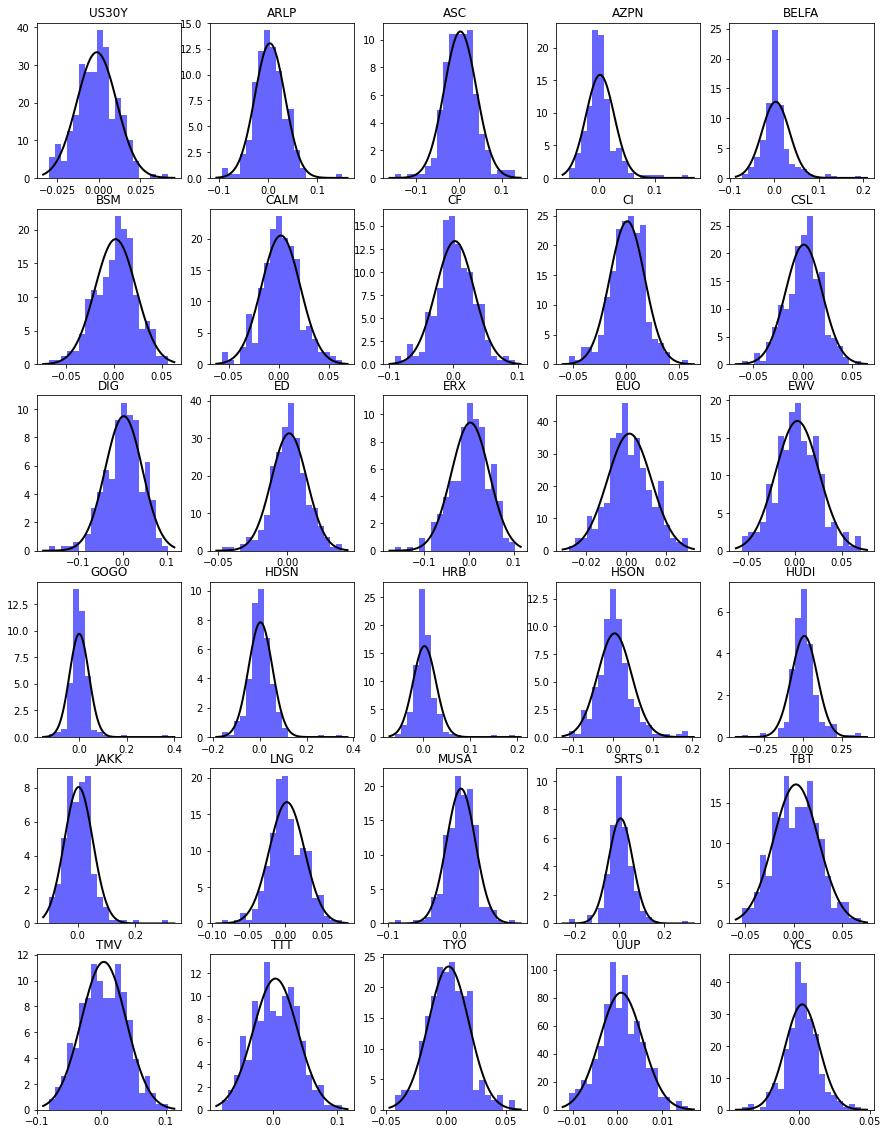

In [15]:
#Compare the distributions of the actual returns of the assets with the hypothetical normal distributions

fig, axs = plt.subplots(nrows=6,ncols=5,figsize=(15, 20))

for i in range(0,30):
    mu, std = stats.norm.fit(returns.iloc[:,i]) 
    axs[i//5, i%5].hist(returns.iloc[:,i], bins=20, density=True, alpha=0.6, color='b')
    xmin, xmax = axs[i//5, i%5].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axs[i//5, i%5].plot(x, p, 'k', linewidth=2)
    axs[i//5, i%5].set_title(returns.columns[i])

plt.show()

Most of the distributions are approximately normal. However, there are a few assets such as AZPN and LNG with distributions somewhat different from their hypothetical normal distributions. We see that it may be inappropriate to use VaR to measure the risk of individual assets. But what about our portfolio? We can check the distrubution of the returns of our portfolio. Addtionally, we compare it with the returns of the S&P 500 ("^GSPC"), Dow Jones ("^DJI"), and Nasdaq Composite ("^IXIC") indexes, which are diversified market portfolios.

[*********************100%***********************]  3 of 3 completed


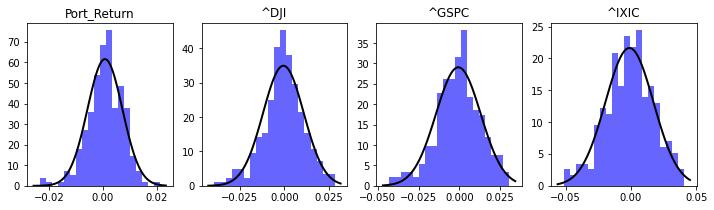

In [16]:
#Compare the distribution of the actual returns of the entire portfolio with the hypothetical normal distribution
#Adding the data of the S&P 500 ("^GSPC"), Dow Jones ("^DJI"), and Nasdaq Composite ("^IXIC") indexes for comparison

#Retrieve the prices of the indexes and calculate the daily returns
tickers = ["^GSPC", "^DJI", "^IXIC"]
index_data = pdr.DataReader(tickers, start, end , data_source='yahoo')
index_price = index_data['Adj Close']
index_returns = index_price.pct_change().dropna()
index_returns = port_returns.merge(index_returns, how="inner", left_index=True, right_index=True)

#Plot the distributions
fig, axs = plt.subplots(nrows=1,ncols=4,figsize=(12, 3))

for i in range(0,4):
    mu, std = stats.norm.fit(index_returns.iloc[:,i]) 
    axs[i].hist(index_returns.iloc[:,i], bins=20, density=True, alpha=0.6, color='b')
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axs[i].plot(x, p, 'k', linewidth=2)
    axs[i].set_title(index_returns.columns[i])

plt.show()


As we can see, the returns of a well diversified portfolio is approximately normal, even though the returns of the individual assets in the portfolio are not.

Since we have the data available, let's compare the historical performance of our portfolio to the performance of the three market indexes.

In [17]:
#Compare the mean and standard deviation of our portfolio to the three indexes
pd.DataFrame({"mean" : index_returns.mean(), "std" : index_returns.std()})

,mean,std
Port_Return,0.000767,0.006483
^DJI,-0.000592,0.011442
^GSPC,-0.000664,0.013751
^IXIC,-0.001134,0.018472


Our portfolio has the highest expected daily return and the lowest volatility. We can also confirm that our portfolio has smaller fluctuation than the three market indexes

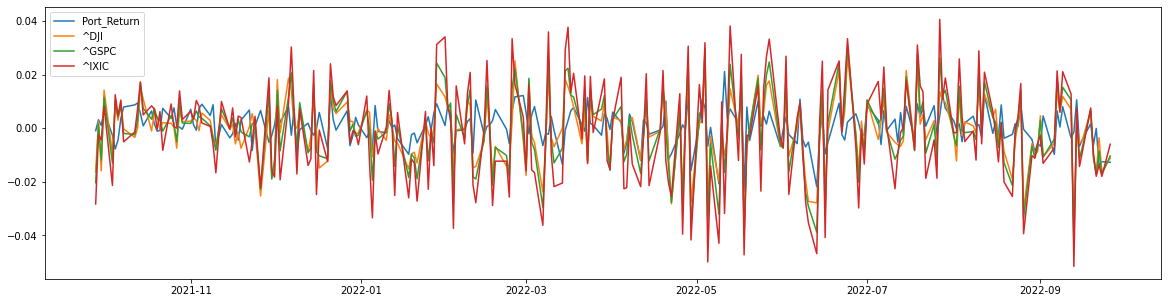

In [18]:
#Plot the movements of the daily returns of our portfolio and the three indexes
plt.figure(figsize=(20, 5))
plt.plot(index_returns)
plt.legend(index_returns.columns)

plt.show()

## Conclusion

In this analysis, we calcualted the Percent Return at Risk and Value at Risk using the Parametric Method. The daily Percent Return at Risk of our portfolio is -0.9897% and the daily Value at Risk is $814,110.08. We also have the following findings:
- The calculated daily Percent Return at Risk is consistent with the historical returns. Our calculated numbers are plausible.
- The returns of each individual asset in a portfolio may not be normal, but returns of a well diversified portfolio is approximately normal. Hence, it may be inappropriate to use VaR to measure the risk of individual asset, but it is reasonable to do so for well diversified portfolios.
- Our portfolio has better historical performance than the S&P 500, Dow Jones, and Nasdaq Composite ("^IXIC") indexes

Additional  Insight:
The risk management of using VaR is also based on another assumption that the distribution of the returns is approximately stable over time. This may be valid for a short period, but for long term capital management, we need to handle the problem of volatility clustering.